In [112]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

DEVICE = "cuda"

# Loading the Data

In [32]:
#Loading dataset
trainData = np.load("data/train.npz") 
testData = np.load("data/test.npz")

Xtrain, Ytrain = torch.Tensor(trainData["x"]).to(DEVICE), torch.Tensor(trainData["y"]).to(DEVICE)
Xtest, Ytest = torch.Tensor(testData["x"]).to(DEVICE), torch.Tensor(testData["y"]).to(DEVICE)

trainDataset = torch.utils.data.TensorDataset(Xtrain, Ytrain)
testDataset = torch.utils.data.TensorDataset(Xtest, Ytest)

dataLoader = torch.utils.data.DataLoader(trainDataset, batch_size=64, shuffle=True)

In [33]:
dataiter = iter(dataLoader)
images, labels = next(dataiter)
print(images.shape)
print(torch.min(images), torch.max(images))

torch.Size([64, 28, 28])
tensor(0., device='cuda:0') tensor(1., device='cuda:0')


# AE Model

In [28]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

# VAE Model

In [ ]:
class VariationalAE(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        pass

# Training

In [44]:
model = AutoEncoder().to(DEVICE)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [69]:
EPOCHS = 50

losses = []
outputs = []

for e in tqdm(range(EPOCHS)):
    for img, label in dataLoader:
        img = img.flatten(start_dim=1, end_dim=2)
        
        generated = model.forward(img)
        l = loss(img, generated)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

    losses.append(l.item())
    outputs.append((img.cpu().detach().reshape(-1, 28, 28), generated.cpu().detach().reshape(-1, 28, 28)))


100%|██████████| 50/50 [01:57<00:00,  2.35s/it]


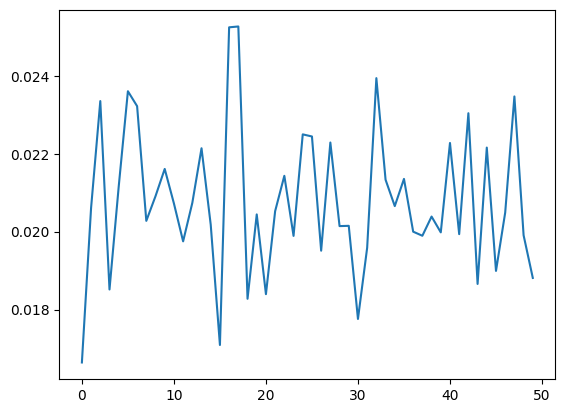

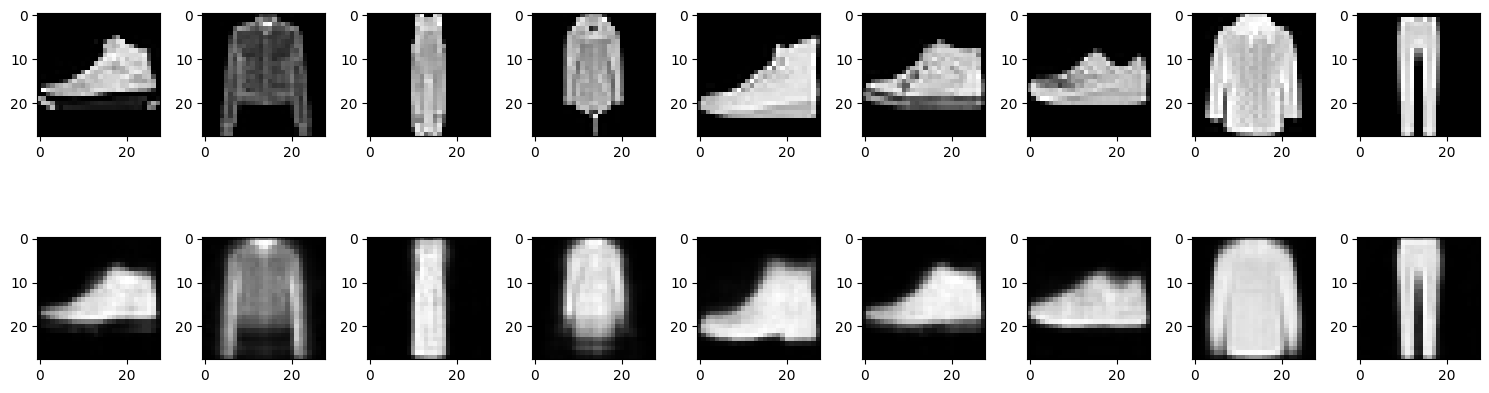

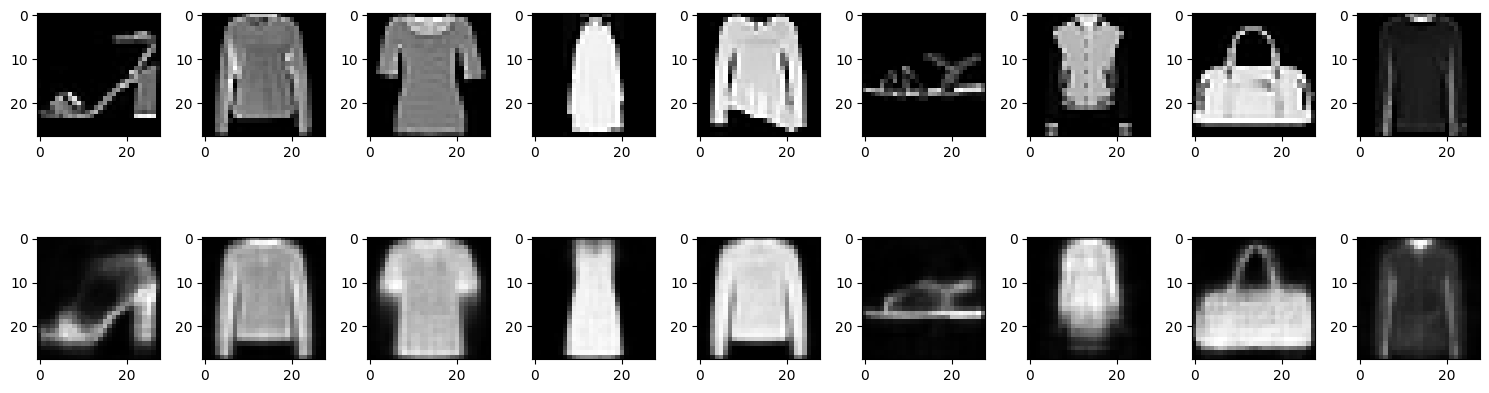

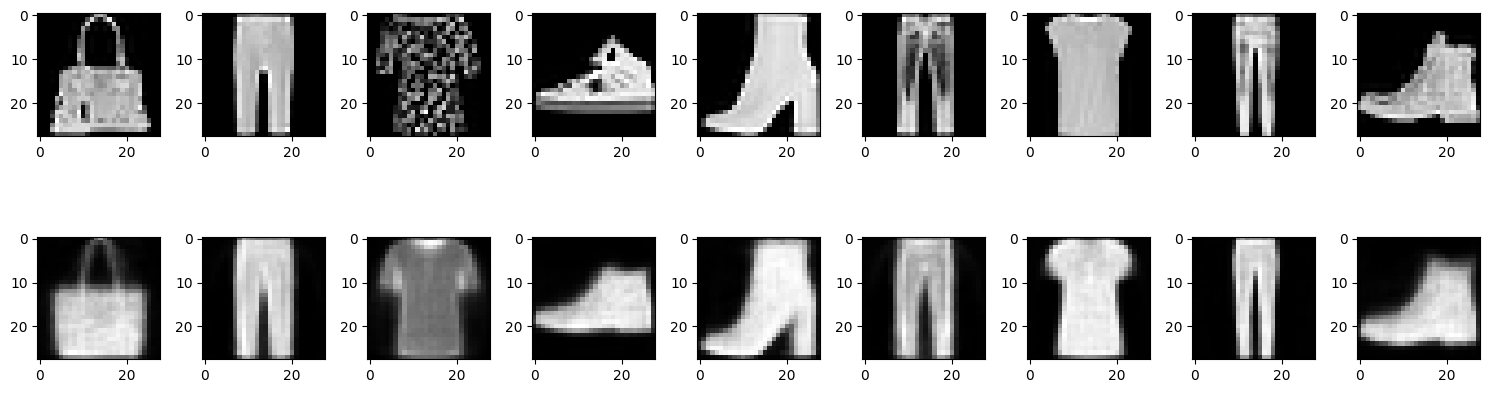

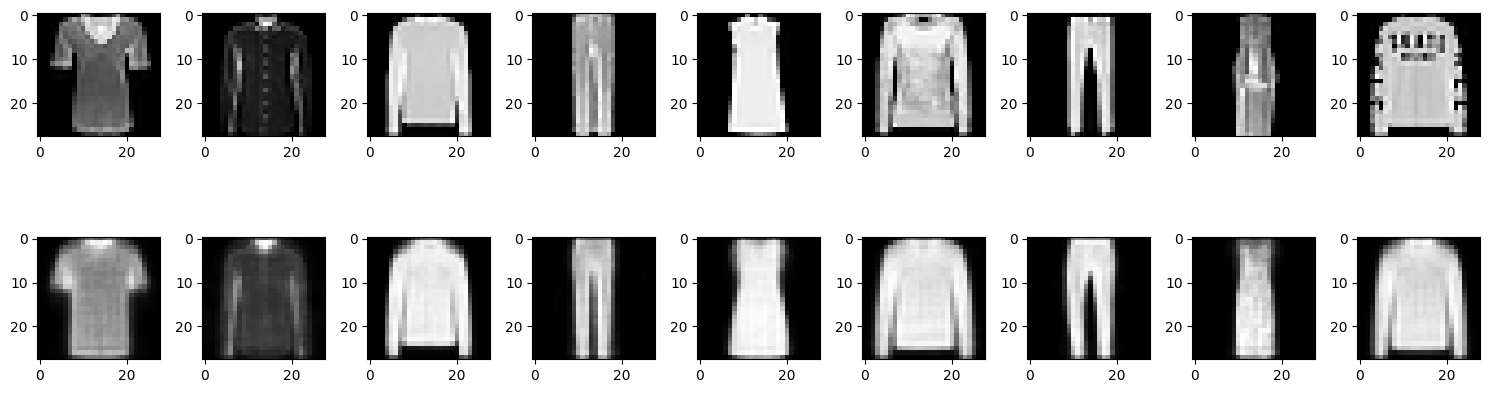

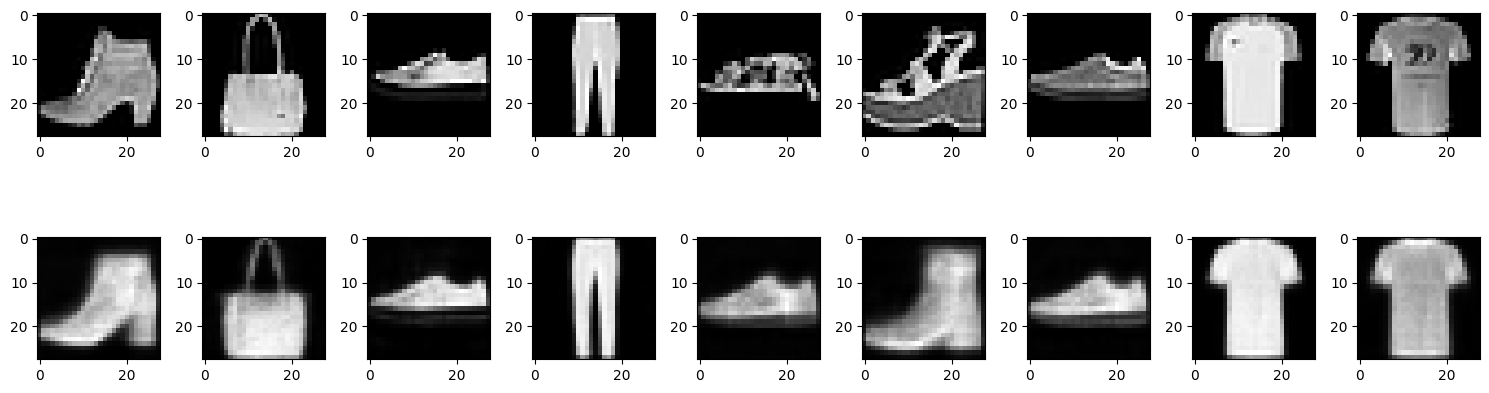

In [80]:
plt.plot(losses)
plt.show()


for k in range(0, EPOCHS, 10):
    plt.figure(figsize=(15, 5))
    plt.gray()
    for i in range(9):
        plt.subplot(2, 9, i+1)
        plt.imshow(outputs[k][0][i])
        plt.subplot(2, 9, (i+1)+9)
        plt.imshow(outputs[k][1][i])

    plt.tight_layout()
    plt.show()


# Generating

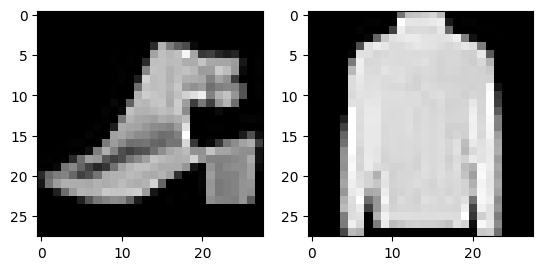

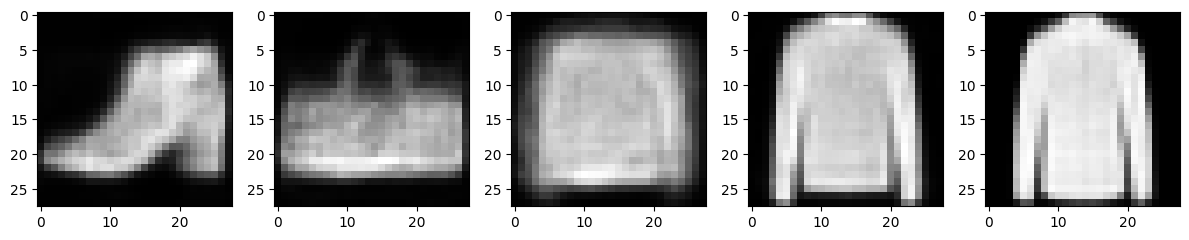

In [99]:
def interpolate(model, img1, img2, n=5):
    img1 = torch.Tensor(img1).to(DEVICE).flatten()
    img2 = torch.Tensor(img2).to(DEVICE).flatten()
    with torch.no_grad():
        latent1 = model.encoder(img1)
        latent2 = model.encoder(img2)
    ts = torch.linspace(0.0, 1.0, n)
    interpolations = [latent1 + (latent2 -latent1)*t for t in ts]
    plt.figure(figsize=(12, 5))
    for i in range(n):
        img = model.decoder(interpolations[i])
        plt.subplot(1, n, i+1)
        plt.imshow(img.cpu().detach().reshape(28, 28))
    plt.tight_layout()
    plt.show()

randomness = np.random.randint(0, 10)
img1 = outputs[randomness][0][0]
img2 = outputs[randomness][0][10]
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.show()

interpolate(model, img1, img2)

# Clustering

In [139]:
with torch.no_grad():
    latentSpaces = []
    for img, label in dataLoader:
        img = img.flatten(start_dim=1, end_dim=2)
        latent = model.encoder(img).cpu()
        latentSpaces.extend(latent)
latentSpaces = np.array(latentSpaces)

pca = PCA(n_components=2)
latent2d = pca.fit_transform(latentSpaces)
print(latent2d.shape)
y = Ytrain.cpu().numpy().astype(int)
unique_labels = np.unique(y)
colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "yellow", "cyan"]

np.savez_compressed("visualization.npz", y=y, latent3d=latentSpaces, latent2d=latent2d)

(60000, 2)


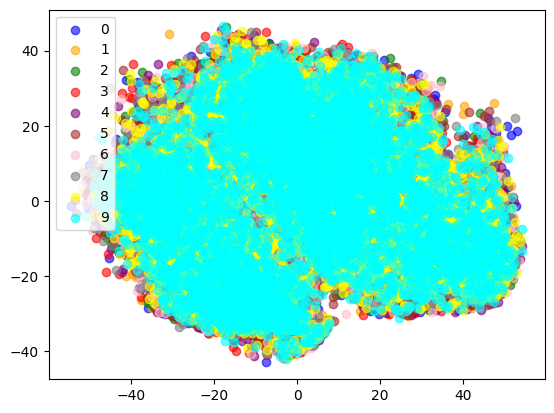

In [138]:
for i, label in enumerate(unique_labels):
    mask = (y == label)
    plt.scatter(latent2d[mask, 0], latent2d[mask, 1],
                color=colors[i], label=str(label), alpha=0.6)
plt.legend()
plt.show()